# Проект 5. Компьютер говорит «Нет»
## Цель проекта: Разаработать скоринговую модель предсказания возможности дефолта клиетнов банка

## Задачи:
* Подготовить датасет к анализу EDA
* Выявить зависимости между отдельными признаками датасета
* Выявить вес наиболее значимых признаков
* создать модель и обучить ее на обучающем датасете
* По метрикам качества оценить качество модели


## import

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, multilabel_confusion_matrix
import pandas_profiling
from sklearn.preprocessing import Normalizer, normalize
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

import warnings

In [2]:
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## DATA

In [4]:
DATASETS_LOC = ('../input/sf-dst-scoring')


In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:

df_train = pd.read_csv(f'{DATASETS_LOC}/train.csv')
df_test = pd.read_csv(f'{DATASETS_LOC}/test.csv')
sample_submission = pd.read_csv(f'{DATASETS_LOC}/sample_submission.csv')


## Functions

In [7]:
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    column_median = df[column].median()

    # Apply filter with respect to IQR, including optional whiskers
    # else mode()

    return df[column].apply(lambda x: x if (x > low_outlier and x < high_outlier) else column_median)

In [8]:
def bin_plot(col):
    """Does plot the binary features visualisation"""
    labels = list(data.query('default == 1')[col].value_counts().index)

    total = data[col].value_counts()
    defaulters = data.query('default==1')[col].value_counts()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, total, width,  label='Total')
    rects2 = ax.bar(x + width/2, defaulters, width, color = 'r', label='Defaulters')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Amount')
    ax.set_title('Defaulters 0/1 in feature {}'.format(col))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    print('Доля дефолта от общего количества','\n', defaulters/total)

In [9]:
def hist_plot(col):
    plt.figure()
    sns.distplot(data[col][data['default'] == 1], kde = False, color= 'red', hist = True)
    sns.distplot(data[col][data['default'] == 0], kde = False, color= 'blue', hist = True)
    plt.title(col)
    plt.show()

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [13]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [14]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [15]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Значение признаков датасета

Feature | Value	| Type
--------|-------|-----
client_id|	id клиента|	Числовой
app_date|	дата подачи заявки|	Временной
education|	уровень образования	|Категориальный
sex|	пол заёмщика|	Бинарный
age	|возраст заёмщика|	Числовой
car	|флаг наличия автомобиля |	Бинарный
car_type |	флаг автомобиля-иномарки|	Бинарный
decline_app_cnt	|количество отказанных прошлых заявок|	Числовой
good_work|	флаг наличия «хорошей» работы|	Бинарный
score_bki|	скоринговый балл по данным из БКИ|	Числовой
bki_request_cnt|	количество запросов в БКИ|	Числовой
region_rating|	рейтинг региона|	Числовой
home_address|	категоризатор домашнего адреса |	Категориальный
work_address|	категоризатор рабочего адреса|	Категориальный
income|	доход заёмщика	|Числовой
sna	|связь заемщика с клиентами банка	|Категориальный
first_time	|давность наличия информации о заемщике	|Категориальный
foreign_passport|	наличие загранпаспорта|	Бинарный
sample    |  маркер выборки  |Бинарный
default	|наличие дефолта (ЦЕЛЕВОЙ ПРИЗНАК)	|Бинарный

In [18]:
#pandas_profiling.ProfileReport(data)

Как видим, большинство признаков у нас требует очистки и предварительной обработки

## Предобработка и анализ данных EDA

### Временной признак 'app_date'
конвертируем данные признака 'app_date' в формат времени

In [19]:
data.app_date = data.app_date.apply(lambda x: pd.to_datetime(x) if x!=None else x)

Сгенерируем несколько признаков для выявления зависимостей.

In [20]:
data['month'] = data.app_date.dt.month
data['date'] = data.app_date.dt.day
data['dayofweek'] = data.app_date.dt.dayofweek

In [21]:
data = data.drop(['app_date'], axis =1)  #удалим за ненадобностью

## Числовые признаки

In [22]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
           'income', 'score_bki', 'region_rating'] #Числовые данные */ без client_id

### Признак 'age'


Распределение возрастов в категориях плательщиков и неплательщиков

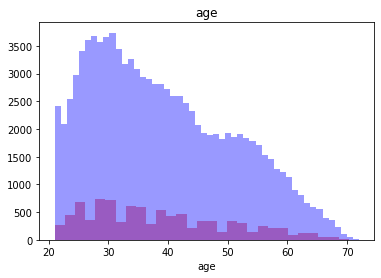

In [23]:
hist_plot('age')

<AxesSubplot:xlabel='default', ylabel='age'>

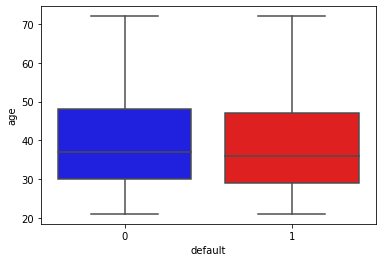

In [24]:
sns.boxplot(x='default', y='age',  data=data, palette={0: "blue", 1: "red"})

In [25]:
data.groupby(data['default'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,39.316742,11.517875,21.0,30.0,37.0,48.0,72.0
1,9372.0,38.525395,11.495797,21.0,29.0,36.0,47.0,72.0


### Признак 'decline_app_cnt'

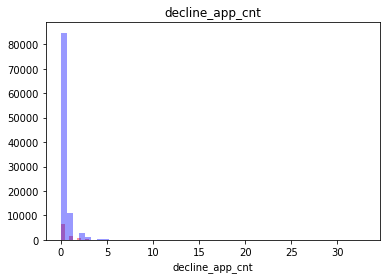

In [26]:
hist_plot('decline_app_cnt')

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

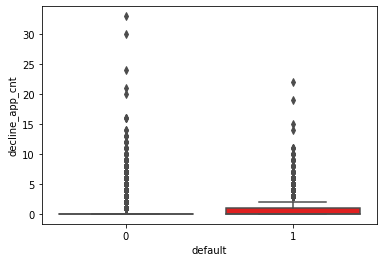

In [27]:
sns.boxplot(x='default', y='decline_app_cnt',  data=data, palette={0: "blue", 1: "red"})


Распределение по количеству отказов в кредите в категориях плательщиков и неплательщиков

In [28]:

data.groupby(data['default'])['decline_app_cnt'].describe()


,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,0.250675,0.756137,0.0,0.0,0.0,0.0,33.0
1,9372.0,0.515472,1.137104,0.0,0.0,0.0,1.0,22.0


In [29]:
part = data.decline_app_cnt.value_counts()[0] #наибольшее количество строк с одним значением
gen = data.shape[0] #общее количество строк

print("часть строк с '0' значением  в признаке 'decline_app_cnt' составляет {:.2f}% от общего числа.".format(part/gen*100))


часть строк с '0' значением  в признаке 'decline_app_cnt' составляет 83.04% от общего числа.


#### исходя из данных в признаке, где 83% тех, кто не имел отказа, а абсллютное большинство из остальных 17% имеют только 1 отказ в получении кредита, заменим признак на бинарный, где 0- отказов не было, а 1-отказы были. 

In [30]:
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: 1 if x >= 1 else 0)

In [31]:
data.decline_app_cnt.value_counts() #Проверка

0    91471
1    18677
Name: decline_app_cnt, dtype: int64

запишем этот признак в бинарный и уберем из числового

In [32]:
num_cols.remove('decline_app_cnt')
num_cols #Проверка

['age', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

### Признак 'bki_request_cnt'

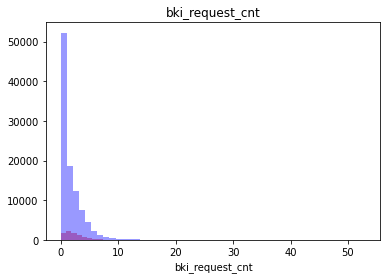

In [33]:
hist_plot('bki_request_cnt')

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

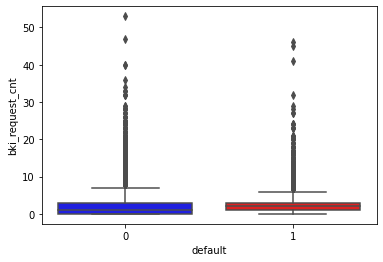

In [34]:
sns.boxplot(x='default', y='bki_request_cnt',  data=data, palette={0: "blue", 1: "red"})

##### Распределение по количеству запросов в БКИ  в категориях плательщиков и неплательщиков

In [35]:
data.groupby(data['default'])['bki_request_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,1.962471,2.214528,0.0,0.0,1.0,3.0,53.0
1,9372.0,2.462335,2.726922,0.0,1.0,2.0,3.0,46.0


### Признак 'income'

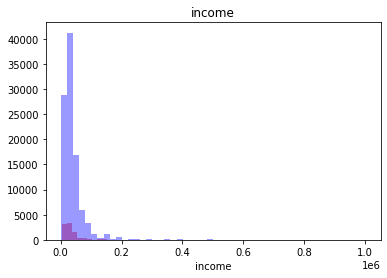

In [36]:
hist_plot('income')

<AxesSubplot:xlabel='default', ylabel='income'>

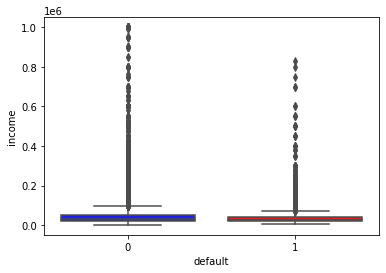

In [37]:
sns.boxplot(x='default', y='income',  data=data, palette={0: "blue", 1: "red"})

##### Распределение по доходам в категориях плательщиков и неплательщиков

In [38]:
data.groupby(data['default'])['income'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,41452.022436,45842.903800,1000.0,20000.0,30000.0,50000.0,1000000.0
1,9372.0,36288.113316,40026.389614,3700.0,20000.0,28000.0,40000.0,830000.0


### Признак 'score_bki'

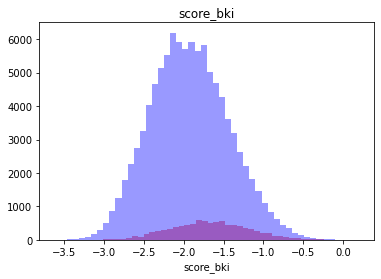

In [39]:
hist_plot('score_bki')

<AxesSubplot:xlabel='default', ylabel='score_bki'>

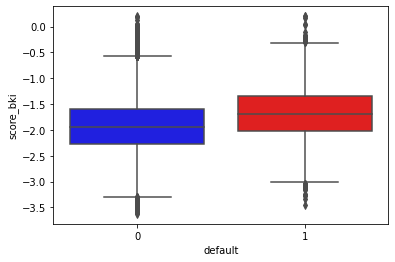

In [40]:
sns.boxplot(x='default', y='score_bki',  data=data, palette={0: "blue", 1: "red"})

##### Распределение по оценкам БКИ в категориях плательщиков и неплательщиков

In [41]:
data.groupby(data['default'])['score_bki'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,-1.925822,0.494479,-3.624586,-2.275984,-1.943587,-1.593718,0.199773
1,9372.0,-1.675637,0.494691,-3.456086,-2.015871,-1.683857,-1.337922,0.199773


### Признак 'region_rating'

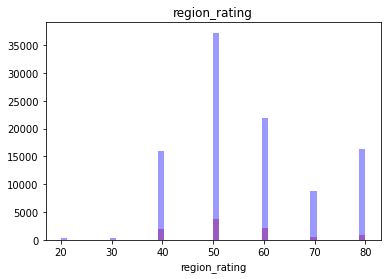

In [42]:
hist_plot('region_rating')

<AxesSubplot:xlabel='default', ylabel='region_rating'>

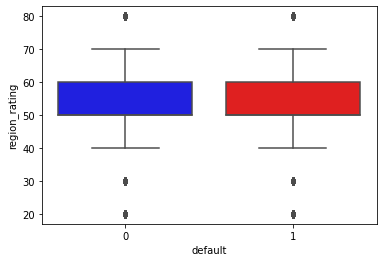

In [43]:
sns.boxplot(x='default', y='region_rating',  data=data, palette={0: "blue", 1: "red"})

##### Распределение по рейтингу регионов в категориях плательщиков и неплательщиков

In [44]:
data.groupby(data['default'])['region_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,100776.0,57.036993,13.131114,20.0,50.0,50.0,60.0,80.0
1,9372.0,53.677977,11.918337,20.0,50.0,50.0,60.0,80.0


### Все числовые данные содержат выбросы и несбалансированы
### для корректой работы скоринговой модели заменим выбросы на медианные значения по каждому признаку

In [45]:
for col in num_cols:
    data[col] = subset_by_iqr(data, col, whisker_width=1.5)

In [46]:
data[num_cols].describe() # проверяем распределение числовых признаков

,age,bki_request_cnt,income,score_bki,region_rating
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,39.249410,1.764635,32165.580201,-1.909583,52.238806
std,11.518063,1.660476,16706.622124,0.488131,8.176620
min,21.000000,0.000000,1000.000000,-3.298952,40.000000
25%,30.000000,0.000000,20000.000000,-2.259268,50.000000
50%,37.000000,1.000000,30000.000000,-1.920823,50.000000
75%,48.000000,3.000000,40000.000000,-1.574614,60.000000
max,72.000000,7.000000,89000.000000,-0.530358,70.000000


In [47]:
data[num_cols].isna().sum() # NAN значения в числовых данных

age                0
bki_request_cnt    0
income             0
score_bki          0
region_rating      0
dtype: int64

### Значимость числовых переменных

<AxesSubplot:>

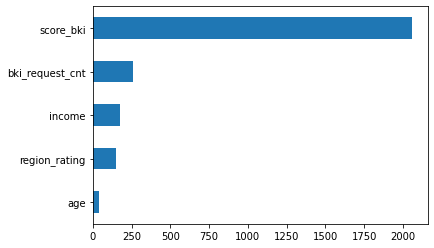

In [48]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Бинарные признаки

In [49]:
bin_cols = ['decline_app_cnt','sex','car', 'car_type', 'good_work', 'foreign_passport']

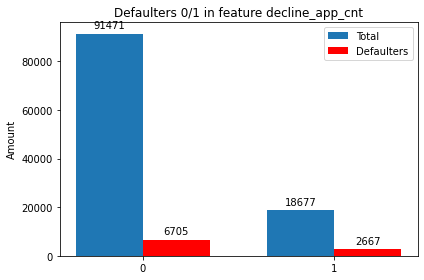

Доля дефолта от общего количества 
 0    0.073302
1    0.142796
Name: decline_app_cnt, dtype: float64


In [50]:
bin_plot('decline_app_cnt')

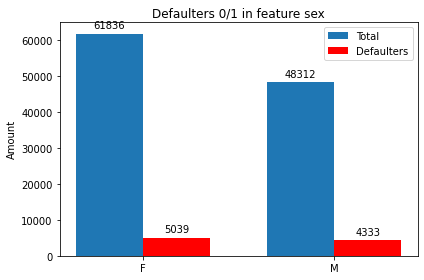

Доля дефолта от общего количества 
 F    0.081490
M    0.089688
Name: sex, dtype: float64


In [51]:
bin_plot('sex')

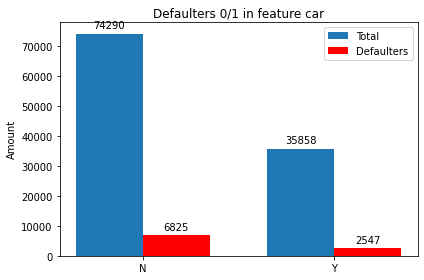

Доля дефолта от общего количества 
 N    0.09187
Y    0.07103
Name: car, dtype: float64


In [52]:
bin_plot('car')

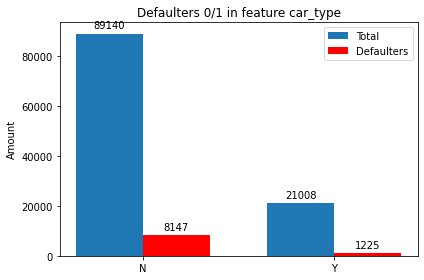

Доля дефолта от общего количества 
 N    0.091396
Y    0.058311
Name: car_type, dtype: float64


In [53]:
bin_plot('car_type')

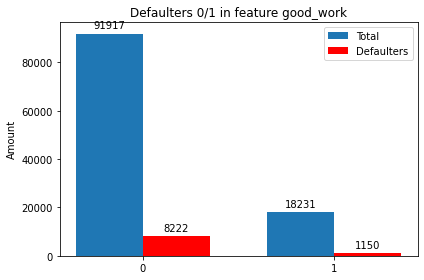

Доля дефолта от общего количества 
 0    0.089450
1    0.063079
Name: good_work, dtype: float64


In [54]:
bin_plot('good_work')

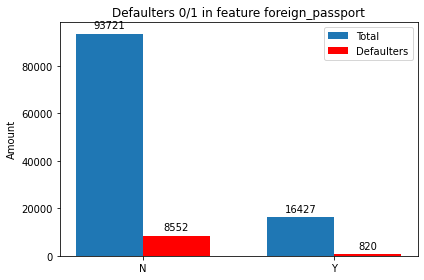

Доля дефолта от общего количества 
 N    0.091250
Y    0.049918
Name: foreign_passport, dtype: float64


In [55]:
bin_plot('foreign_passport')

### Преобразуем бинарные признаки в числовые переменные

In [56]:
for column in bin_cols:
    data[column] = LabelEncoder().fit_transform(data[column])

In [57]:
 data[bin_cols].head() #убедимся в преобразовании

,decline_app_cnt,sex,car,car_type,good_work,foreign_passport
0,0,1,1,1,0,0
1,1,0,0,0,0,0
2,0,1,1,1,0,1
3,0,1,0,0,0,0
4,0,0,0,0,0,0


## Категориальные переменные


In [58]:
cat_cols = ['education', 'home_address',
           'work_address', 'sna', 'first_time']

In [59]:
print('Пропущеных значений {}, что составляет {:.2f}% от общего количества'.format(data.education.isna().sum(), data.education.isna().sum() /data.shape[0]*100))

Пропущеных значений 478, что составляет 0.43% от общего количества


что за данные в 'education'?

In [60]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Приведенная абривеатура может означать уровень образования, где

Graduation's code | Value
-----|-------------------------
SCH  |  school graduated
GRD  |  Graduate Research Degrees
UGR  |  Upper graduated researchers
PGR  |  Post graduated researchers
ACD  |  Upper post graduated degrees


##### Исходя из небольшого процента пропущенных данных, заменим пропущенные значения наиболее встречающимися в выборке

In [61]:
data['education'] = data['education'].fillna(data['education'].mode()[0])

In [62]:
data.isna().sum() # проверка

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
month               0
date                0
dayofweek           0
dtype: int64

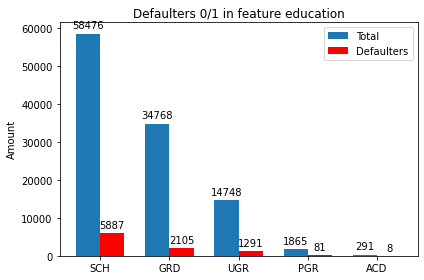

Доля дефолта от общего количества 
 SCH    0.100674
GRD    0.060544
UGR    0.087537
PGR    0.043432
ACD    0.027491
Name: education, dtype: float64


In [63]:
bin_plot('education')

In [64]:
#распределение данных в education
data['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

#### преобразуем признак 'education' в численный формат

In [65]:
data['education'] = LabelEncoder().fit_transform(data['education'])
data['education'].value_counts()

3    58476
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64

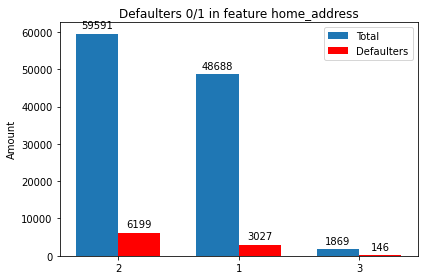

Доля дефолта от общего количества 
 2    0.104026
1    0.062171
3    0.078117
Name: home_address, dtype: float64


In [66]:
bin_plot('home_address')

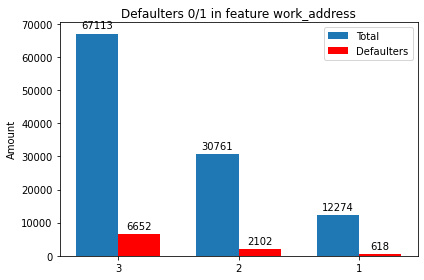

Доля дефолта от общего количества 
 3    0.099116
2    0.068333
1    0.050350
Name: work_address, dtype: float64


In [67]:
bin_plot('work_address')

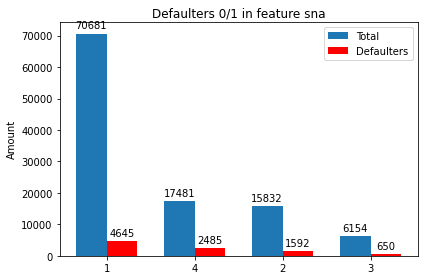

Доля дефолта от общего количества 
 1    0.065718
4    0.142154
2    0.100556
3    0.105622
Name: sna, dtype: float64


In [68]:
bin_plot('sna')

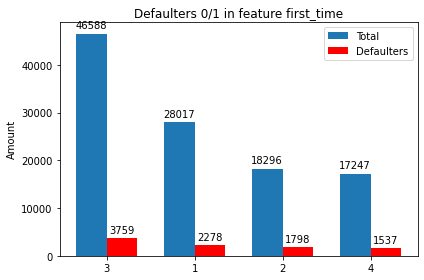

Доля дефолта от общего количества 
 1    0.124508
2    0.104250
3    0.080686
4    0.054860
Name: first_time, dtype: float64


In [69]:
bin_plot('first_time')

### Целевой признак

0    64427
1     9372
Name: default, dtype: int64

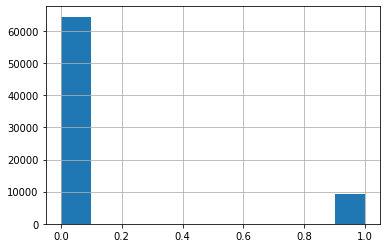

In [70]:
data.query('sample ==1').default.hist()
data.query('sample ==1').default.value_counts()


### Значимость категориальных и бинарных признаков

<AxesSubplot:>

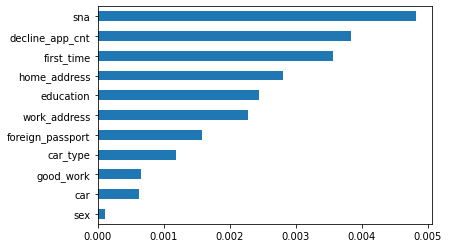

In [71]:

imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  region_rating     110148 non-null  float64
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  float64
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

### посмотрим вновь на таблицу корреляции 

In [73]:
corr = data.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Heatmap")\
    .set_precision(2)\
    .set_table_styles(magnify())

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,month,date,dayofweek
client_id,1.00,-0.02,-0.03,0.02,-0.02,-0.02,-0.02,0.00,-0.06,-0.00,0.00,0.16,0.16,-0.00,-0.00,0.02,-0.01,0.00,-0.03,0.97,0.09,-0.03
education,-0.02,1.00,-0.02,0.01,-0.11,-0.15,0.06,-0.15,0.04,-0.03,-0.03,0.01,0.01,-0.20,0.10,-0.12,-0.14,-0.00,0.06,-0.02,-0.00,0.01
sex,-0.03,-0.02,1.00,-0.13,0.28,0.22,0.02,-0.04,-0.05,-0.05,0.05,0.04,0.07,0.27,-0.00,0.01,0.09,-0.01,0.01,-0.03,-0.01,0.01
age,0.02,0.01,-0.13,1.00,-0.05,-0.04,-0.11,-0.07,-0.11,0.04,-0.06,0.01,-0.00,-0.12,-0.06,0.08,-0.04,0.00,-0.02,0.01,0.01,-0.01
car,-0.02,-0.11,0.28,-0.05,1.00,0.70,-0.04,0.00,-0.04,-0.05,0.03,-0.02,-0.01,0.25,-0.07,0.09,0.11,-0.00,-0.03,-0.02,-0.01,-0.02
car_type,-0.02,-0.15,0.22,-0.04,0.70,1.00,-0.05,0.02,-0.04,-0.02,0.04,-0.01,0.00,0.28,-0.09,0.10,0.15,-0.00,-0.05,-0.02,-0.01,-0.02
decline_app_cnt,-0.02,0.06,0.02,-0.11,-0.04,-0.05,1.00,-0.04,0.19,0.08,-0.01,0.01,0.02,-0.00,0.07,-0.08,-0.03,0.00,0.09,-0.02,-0.01,0.01
good_work,0.00,-0.15,-0.04,-0.07,0.00,0.02,-0.04,1.00,0.01,0.01,0.02,-0.01,-0.01,0.05,-0.05,0.06,0.05,-0.00,-0.04,0.00,-0.00,0.00
score_bki,-0.06,0.04,-0.05,-0.11,-0.04,-0.04,0.19,0.01,1.00,0.11,0.01,0.01,0.02,0.02,0.07,-0.07,-0.02,-0.00,0.14,-0.06,0.00,-0.00
bki_request_cnt,-0.00,-0.03,-0.05,0.04,-0.05,-0.02,0.08,0.01,0.11,1.00,0.00,-0.00,-0.01,0.05,0.01,0.01,-0.01,-0.00,0.05,-0.01,0.01,0.01


#### выявлены сильные корреляции между:
    * car и car_type
    * home_address и work_address
    * client_id и month


In [74]:
data.drop(['client_id','work_address','car_type'], axis = 1, inplace=True) # удаление сильно скоррелированных признаков

In [75]:
cat_cols.remove('work_address')



In [76]:
bin_cols.remove('car_type')

### смотрим, что получилось

In [77]:
data.sample(10)

,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,sample,default,month,date,dayofweek
87126,3,1,21,0,0,0,-2.031362,2.0,50.0,2,45000.0,2,2,0,1,0,2,26,2
21819,3,1,41,0,1,0,-2.064949,2.0,50.0,2,10000.0,4,1,0,0,0,4,8,1
9946,1,0,49,0,0,0,-1.865266,5.0,70.0,2,30000.0,2,3,0,0,0,2,28,4
40410,3,0,23,1,0,0,-1.970219,2.0,50.0,2,33000.0,3,3,0,1,0,3,13,3
74921,1,0,32,0,0,0,-1.318264,1.0,50.0,2,46000.0,4,1,0,1,0,4,3,3
20771,3,0,39,0,0,0,-2.794111,0.0,60.0,2,50000.0,1,3,0,0,0,2,11,1
11883,3,1,40,1,0,0,-1.844479,1.0,50.0,3,80000.0,1,3,0,0,0,3,12,2
35653,1,0,37,0,0,0,-1.755285,4.0,60.0,1,35000.0,1,3,1,0,0,3,20,3
102609,3,0,56,0,0,0,-0.944863,1.0,60.0,1,25000.0,1,4,0,1,1,3,1,5
10220,3,1,34,1,1,0,-2.427334,2.0,50.0,1,45000.0,1,2,0,0,0,3,16,6


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  int64  
 3   car               110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  int64  
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   region_rating     110148 non-null  float64
 9   home_address      110148 non-null  int64  
 10  income            110148 non-null  float64
 11  sna               110148 non-null  int64  
 12  first_time        110148 non-null  int64  
 13  foreign_passport  110148 non-null  int64  
 14  sample            110148 non-null  int64  
 15  default           110148 non-null  int64  
 16  month             11

#### после проведения предобработки данных и анализа EDA разделим вновь датасет на тренировочную и тестовую выборки


In [79]:
df_train =  data.query('sample == 1').drop(['sample'], axis=1)
df_test = data.query('sample == 0').drop(['sample'], axis=1)

y = df_train.default.values # наш таргет
df_train = df_train.drop(['default'], axis=1)

## Preprocessing

In [80]:
X_cat =  OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)

#### Стандартизируем числовые переменные

In [81]:
X_num = StandardScaler().fit_transform(df_train[num_cols].values)

In [82]:
df_train.sample(3)

,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,month,date,dayofweek
59809,1,0,31,0,0,0,-2.225004,3.0,50.0,2,40000.0,1,3,0,3,14,4
40058,4,0,55,0,0,0,-1.879065,7.0,60.0,2,49000.0,4,1,0,3,28,4
57911,1,1,60,1,0,1,-2.694520,2.0,50.0,1,30000.0,1,3,1,4,17,3


In [83]:
df_test.sample(3)

,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,default,month,date,dayofweek
12187,1,0,29,0,0,0,-2.616177,5.0,50.0,2,30000.0,2,2,0,0,3,18,1
14018,4,0,27,0,0,0,-1.774186,0.0,70.0,1,45000.0,4,3,0,0,2,19,2
7501,3,1,25,0,0,0,-2.225004,1.0,50.0,1,30000.0,4,1,0,0,3,24,0


#### И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.


In [84]:
X = np.hstack([X_num, df_train[bin_cols].values, X_cat])

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации.
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [85]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [86]:
# проверяем
df_test.shape, df_train.shape, X.shape, X_train.shape, X_test.shape

((36349, 18), (73799, 17), (73799, 26), (59039, 26), (14760, 26))

## Model

In [87]:
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train,y_train)
y_pred = lg.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc =  roc_auc_score(y_test, y_pred)


## Оценка качества модели

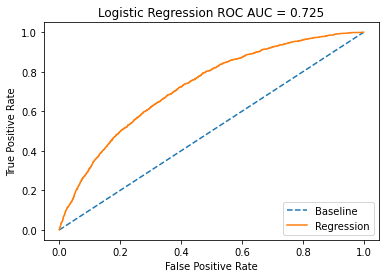

In [88]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### на этом месте должны быть гипперпараметры :-)

In [89]:
y_pred

array([0.20640388, 0.15330431, 0.13977367, ..., 0.0915886 , 0.07954377,
       0.05849598])

#### Давайте найдем оптимальное значение параметра регуляризации для логистической регрессии.

In [90]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

In [91]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)


In [92]:

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

In [93]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(lg, hyperparameters, cv=5, verbose=0)

In [94]:
best_model = clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

In [95]:
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
